In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

import re
import string
import nltk
from nltk.corpus import stopwords


import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

2022-12-15 08:49:36.017419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# for plotting graphs and visualization
from plotly.offline import iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
from wordcloud import WordCloud

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
## EDA

In [5]:
train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11118


The columns:

- `textID`: Text ID of the tweet
- `text`: Text of the tweet
- `selected_text`: Polarity of the tweet
- `sentiment`: Sentiment of the tweet

## General EDA

### Missing values
Checking if there are missing values in the data. 

In [10]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [12]:
test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [13]:
# dropping the missing values
train.dropna(axis=0, how='any', inplace=True)

In [6]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
print(temp)

  sentiment   text
1   neutral  11117
2  positive   8582
0  negative   7781


In [7]:
print(f"Train sentiment: \n{(train['sentiment'].value_counts(normalize=True)) * 100}")
print(f"\n")
print(f"Test sentiment: \n{(test['sentiment'].value_counts(normalize=True)) * 100}")

Train sentiment: 
neutral     40.457043
positive    31.228849
negative    28.314108
Name: sentiment, dtype: float64


Test sentiment: 
neutral     40.464063
positive    31.211092
negative    28.324844
Name: sentiment, dtype: float64


In [8]:
train['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='blue',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

In [9]:
test['sentiment'].value_counts(normalize=True).iplot(kind='bar',
                                                      yTitle='Percentage', 
                                                      linecolor='black', 
                                                      opacity=0.7,
                                                      color='black',
                                                      theme='pearl',
                                                      bargap=0.7,
                                                      gridcolor='white',
                                                     
                                                      title='Distribution of Sentiment column in the training set')

# Text Data Processing 

We will pre-process our data to make it into consistent format. 

- Make texts lowercase
- Remove hyperlinks and punctuations
- Remover numbers
- Tokenizes
- Remove stopwords

In [4]:
def clean_text(text):
    """
    Removes:
        - Texts in square brackets
        - Links
        - Punctuations
        - Words containing numbers

    Makes texts lowercase
    """
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [5]:
def text_preprocessing(text):
    """
    - Tokenizes
    - Remove stopwords 
    - Clean text
    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    no_punctuation = clean_text(text)
    
    tokenized_text = tokenizer.tokenize(no_punctuation)
    remove_stopwords = [word for word in tokenized_text if word not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    
    return combined_text

In [6]:
train['text'] = train['text'].apply(str).apply(lambda x : text_preprocessing(x))

train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id responded going,"I`d have responded, if I were going",neutral
1,549e992a42,sooo sad miss san diego,Sooo SAD,negative
2,088c60f138,boss bullying,bullying me,negative
3,9642c003ef,interview leave alone,leave me alone,negative
4,358bd9e861,sons couldnt put releases already bought,"Sons of ****,",negative


In [7]:
# Similarly, for test data
test['text'] = test['text'].apply(str).apply(lambda x : text_preprocessing(x))

test.head()

,textID,text,sentiment
0,f87dea47db,last session day,neutral
1,96d74cb729,shanghai also really exciting precisely skyscr...,positive
2,eee518ae67,recession hit veronique branquinho quit compan...,negative
3,01082688c6,happy bday,positive
4,33987a8ee5,like,positive


# Text Statistics
We will analyze our texts:
- Text length analysis
- Word frequency analysis

Adding `text_length` and `text_word_count` columns for our analysis

In [24]:
train['text_length'] = train['text'].astype(str).apply(len) # counts the spaces as well
train['text_word_count'] = train['text'].apply(lambda x : len(str(x).split()))

In [25]:
# 3 different dataframes for our sentiment
positive = train[train['sentiment'] == 'positive']
negative = train[train['sentiment'] == 'negative']
neutral = train[train['sentiment'] == 'neutral']

## Sentence length analysis

The histogram shows that the length of the cleaned text ranges from around 2 to 140 characters and generally,it is almost same for all the polarities.

In [26]:
positive['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='green',
    yTitle='count',
    title='Positive Text Length Distribution')

negative['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    color='red',
    yTitle='count',
    title='Negative Text Length Distribution')

neutral['text_length'].iplot(
    kind='hist',
    bins=100,
    xTitle='text length',
    linecolor='black',
    yTitle='count',
    title='Neutral Text Length Distribution')

Relationship of text length with the sentiment

In [28]:
trace0 = go.Box(
    y=positive['text_length'],
    name = 'Positive Text',
    marker = dict(
        color = 'green',
    )
)

trace1 = go.Box(
    y=negative['text_length'],
    name = 'Negative Text',
    marker = dict(
        color = 'red',
    )
)

trace2 = go.Box(
    y=neutral['text_length'],
    name = 'Neutral Text',
    marker = dict(
        color = 'orange',
    )
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Length of the text"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Length of the text of different polarities")


# Ngram exploration


N-grams are used to describe the number of words used as observation points
- unigram means singly-worded
- bigram means 2-worded phrase
- trigram means 3-worded phrase

![N-gram](https://i.stack.imgur.com/8ARA1.png)

In [29]:
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [31]:
## top unigram 
positive_unigrams = get_top_n_words(positive['text'], 20)
positive_unigrams

[('day', 1223),
 ('good', 1046),
 ('love', 875),
 ('happy', 840),
 ('im', 740),
 ('mothers', 627),
 ('thanks', 553),
 ('great', 478),
 ('like', 413),
 ('hope', 396),
 ('fun', 344),
 ('today', 342),
 ('lol', 338),
 ('nice', 334),
 ('night', 319),
 ('really', 307),
 ('got', 302),
 ('morning', 288),
 ('time', 287),
 ('going', 283)]

In [33]:
negative_unigrams = get_top_n_words(negative['text'], 20)
neutral_unigrams = get_top_n_words(neutral['text'], 20)

In [34]:
df1 = pd.DataFrame(positive_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='green', title='Top 20 Unigrams in positve text',orientation='h')

In [35]:
df1 = pd.DataFrame(neutral_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='orange', title='Top 20 Unigrams in neutral text',orientation='h')

In [36]:
df1 = pd.DataFrame(negative_unigrams, columns = ['Text' , 'count'])
df1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='red', title='Top 20 Unigrams in negative text',orientation='h')

In [47]:
positive_text = train[train['sentiment'] == 'positive']['text']
negative_text = train[train['sentiment'] == 'negative']['text']
neutral_text = train[train['sentiment'] == 'neutral']['text']

# pre-processed selected text column
positive_text_clean = positive_text.apply(lambda x: text_preprocessing(x))
negative_text_clean = negative_text.apply(lambda x: text_preprocessing(x))
neutral_text_clean = neutral_text.apply(lambda x: text_preprocessing(x))

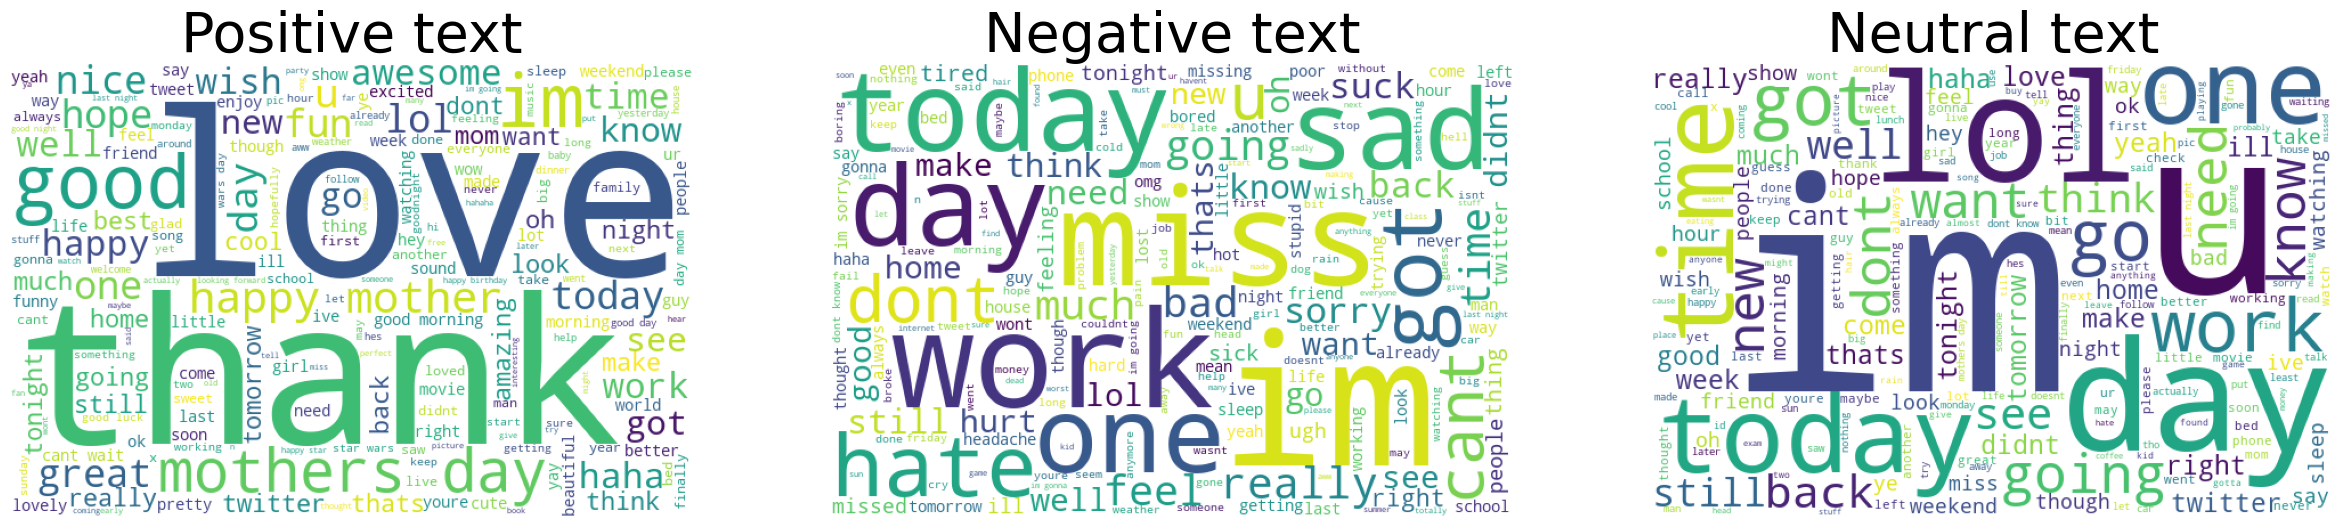

In [48]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(positive_text_clean))

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive text',fontsize=40);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(negative_text_clean))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative text',fontsize=40);

wordcloud3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neutral_text_clean))
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral text',fontsize=40);

### Feature important 
we have only one feature out here so computation of feature importants does not make much sence. 

In [8]:
def encode_class(text):
    if text=="positive":
        return int(1)
    elif text =="negative":
        return int(0)
    else:
        return int(2)

In [9]:
#train=train[train["sentiment"]!="neutral"]
train["sentiment"]= train["sentiment"].apply(lambda x: encode_class(x)  )
test["sentiment"]= test["sentiment"].apply(lambda x: encode_class(x) )


In [11]:
train.sentiment.value_counts()

2    11118
1     8582
0     7781
Name: sentiment, dtype: int64

In [10]:
sentences_train= train["text"].values
sentences_test=test["text"].values
y_train=train["sentiment"].values
y_test=test["sentiment"].values

In [12]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id responded going,"I`d have responded, if I were going",2
1,549e992a42,sooo sad miss san diego,Sooo SAD,0
2,088c60f138,boss bullying,bullying me,0
3,9642c003ef,interview leave alone,leave me alone,0
4,358bd9e861,sons couldnt put releases already bought,"Sons of ****,",0


For a project, you repository/folder should contain the following:

* `README.md` with
  * Description of the problem
  * Instructions on how to run the project
* Data
  * You should either commit the dataset you used or have clear instructions how to download the dataset
* Notebook (suggested name - `notebook.ipynb`) with
  * Data preparation and data clearning
  * EDA, feature importance analysis
  * Model selection process and parameter tuning
* Script `train.py` (suggested name)
  * Training the final model
  * Saving it to a file (e.g. pickle) or saving it with specialized software (BentoML)
* Script `predict.py` (suggested name)
  * Loading the model
  * Serving it via a web serice (with Flask or specialized sofware - BentoML, KServe, etc)
* Files with dependencies
  * `Pipenv` and `Pipenv.lock` if you use Pipenv
  * `bentofile.yaml` if you use BentoML
  * or equivalents: conda environment file, requirements.txt or pyproject.toml
* `Dockerfile` for running the service
* Deployment
  * URL to the service you deployed or
  * Video or image of how you interact with the deployed service

####  Model selection 
Going with default hyparameter setting. list of training algorithm
-   logistic regresssion
-   Decision Tree
-   Random Forest
-   SVM 
-   CNN model


In [12]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [13]:
## logistic regresssion
classifier = LogisticRegression(multi_class='multinomial',class_weight='balanced', solver='lbfgs',max_iter=200)
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.6960950764006791


/Users/jainendra/.local/share/virtualenvs/week-7-Lz0kreyU/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [78]:
## Decision Tree
classifier = DecisionTreeClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.6559139784946236


In [79]:
## Random Forest
classifier = RandomForestClassifier(class_weight='balanced')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.6958121109224674


In [82]:
## Support Vector Machine (SVM)
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier


classifier = OneVsRestClassifier(svm.SVC(gamma=0.01, C=100., probability=True, class_weight='balanced', kernel='linear'))
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print("Accuracy:", score)

In [13]:
## CNN model

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

boss bullying
[1160]


In [14]:
from keras.utils import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:

y_train = utils.to_categorical(y_train, 3)
y_test = utils.to_categorical(y_test, 3)

In [16]:
embedding_dim = 100

model = models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation="sigmoid"))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          2640400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 2,705,851
Trainable params: 2,705,851
Non-trainable params: 0
______________________________________________

2022-12-15 08:32:54.140613: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)


Epoch 1/10
2749/2749 [==============================] - 55s 20ms/step - loss: 0.7709 - accuracy: 0.6654 - val_loss: 0.6742 - val_accuracy: 0.7151
Epoch 2/10
2749/2749 [==============================] - 54s 20ms/step - loss: 0.5869 - accuracy: 0.7668 - val_loss: 0.7008 - val_accuracy: 0.7111
Epoch 3/10
2749/2749 [==============================] - 55s 20ms/step - loss: 0.4120 - accuracy: 0.8488 - val_loss: 0.8092 - val_accuracy: 0.6907
Epoch 4/10
2749/2749 [==============================] - 54s 20ms/step - loss: 0.2603 - accuracy: 0.9111 - val_loss: 1.0202 - val_accuracy: 0.6752
Epoch 5/10
2749/2749 [==============================] - 55s 20ms/step - loss: 0.1693 - accuracy: 0.9421 - val_loss: 1.3217 - val_accuracy: 0.6619
Epoch 6/10
2749/2749 [==============================] - 55s 20ms/step - loss: 0.1216 - accuracy: 0.9590 - val_loss: 1.6164 - val_accuracy: 0.6565
Epoch 7/10
2749/2749 [==============================] - 56s 20ms/step - loss: 0.0904 - accuracy: 0.9694 - val_loss: 1.8142 -

In [18]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9756
Testing Accuracy:  0.6271


## Model Selection & Hyparameter tunning 
-   Algorithm              -------> Accuracy
-   Logistic regresssion   -------> 0.6960
-   Decision Tree          -------> 0.6559
-   Random Forest          -------> 0.6958
-   CNN model              -------> 0.6271

We are going to select one model out of above. i have selected randomforest for fruther hyperparameter tunning and build final model for serving with RestAPI.


In [30]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1,
                                    class_weight='balanced')
        rf.fit(X_train, y_train)

        accuracy = rf.score(X_test, y_test)

        scores.append((d, n, accuracy))

In [31]:
columns = ['max_depth', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

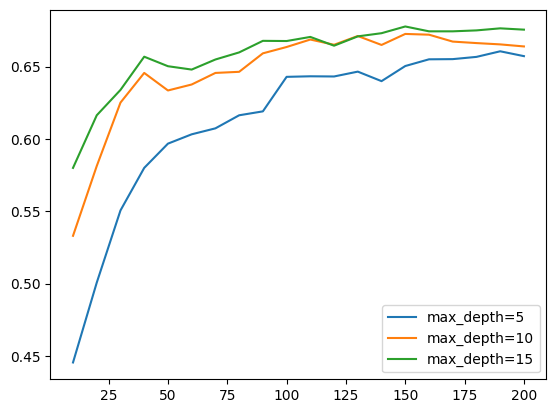

In [32]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             label='max_depth=%d' % d)

plt.legend()

In [33]:
## accuracy best at max_depth == 15
max_depth = 15

In [34]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1,
                                    class_weight='balanced')
        rf.fit(X_train, y_train)
        accuracy = rf.score(X_test, y_test)
        scores.append((s, n, accuracy))

In [35]:
columns = ['min_samples_leaf', 'n_estimators', 'accuracy']
df_scores = pd.DataFrame(scores, columns=columns)

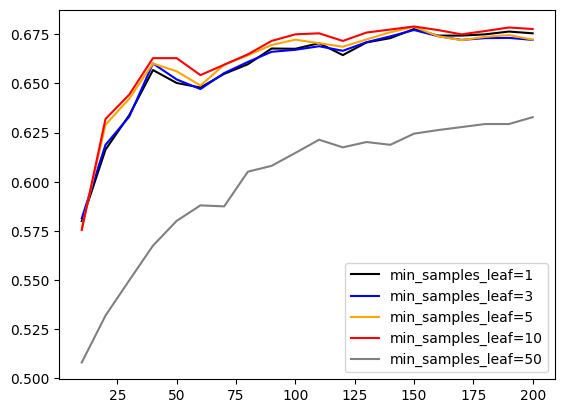

In [36]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [ ]:
## accuracy best at min_samples_leaf=1 with above graph
min_samples_leaf = 1

rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1,
                            class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=1)

In [39]:
df[df["sentiment"]==1].head(10)

,text,sentiment
6,feedings baby fun smiles coos,1
9,journey wow u became cooler hehe possible,1
11,really really like song love story taylor swift,1
21,playing ghost online really interesting new up...,1
25,free fillin app ipod fun im addicted,1
28,juss came backk berkeleyy omg madd fun havent ...,1
30,im going home seen new twitter design quitehea...,1
31,hope unni make audition fighting dahye unni,1
33,thats funny cute kids,1
39,little happy wine jeje ok itsm free time cares...,1


In [1]:
import nltk
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '